# Octank IIoT Data Analytics Notebook
Demonstration of [AWS IoT Analytics](https://aws.amazon.com/iot-analytics/) Notebooks, using real-time sensor data.

In [1]:
import boto3
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters

In [2]:
def parse(x):
    return pd.to_datetime(x,
                          infer_datetime_format=True,
                          unit='s',
                          utc=True)

In [3]:
%%time

# use 'nrows=100' for testing
client = boto3.client("iotanalytics")
dataset = "iot_data_dataset"
data_location = client.get_dataset_content(datasetName=dataset)["entries"][0]["dataURI"]
df = pd.read_csv(data_location,
                 header=0,
                 low_memory=False,
                 infer_datetime_format=True,
                 date_parser=parse,
                 index_col=["ts"])

CPU times: user 2.48 s, sys: 333 ms, total: 2.81 s
Wall time: 4.05 s


In [4]:
df = df.drop(columns="__dt")
df = df.sort_values(by="ts", ascending=True)

In [5]:
print(df.head(5))

                                                 device   humidity       temp  \
ts                                                                              
2020-06-20 23:59:32.175828695+00:00  iot-demo-device-01  82.599998  62.060001   
2020-06-20 23:59:34.272635698+00:00  iot-demo-device-02  70.699997  63.139999   
2020-06-20 23:59:34.980094671+00:00  iot-demo-device-03  45.900002  75.919999   
2020-06-20 23:59:40.765217066+00:00  iot-demo-device-03  45.799999  75.919999   
2020-06-20 23:59:45.992712975+00:00  iot-demo-device-01  82.500000  62.060001   

                                     light  motion       lpg        co  \
ts                                                                       
2020-06-20 23:59:32.175828695+00:00   True   False  0.006710  0.004134   
2020-06-20 23:59:34.272635698+00:00   True   False  0.006748  0.004166   
2020-06-20 23:59:34.980094671+00:00   True   False  0.007472  0.004797   
2020-06-20 23:59:40.765217066+00:00   True   False  0.007461  

In [6]:
print("Dataset Range")
print("-------------")
print("Record count: {:,}".format(df["temp"].count()))
print("-------------")
print("Time range (min): {:%Y-%m-%d %H:%M:%S %Z}".format(df.index[1]))
print("Time range (max): {:%Y-%m-%d %H:%M:%S %Z}".format(df.index[-1]))
print("-------------")
print("Records:\n{}".format(df.groupby("device").size()))

Dataset Range
-------------
Record count: 545,451
-------------
Time range (min): 2020-06-20 23:59:34 UTC
Time range (max): 2020-07-06 21:29:59 UTC
-------------
Records:
device
iot-demo-device-01    158825
iot-demo-device-02    155217
iot-demo-device-03    231409
dtype: int64


In [7]:
# filter time range
df_filtered = df.loc[df.index >= pd.Timestamp('today', tz="UTC").floor('D') + pd.Timedelta(-1, unit='D')]

In [8]:
# filter temp/humidity outliers (>1% & <99%)
df_filtered = df_filtered.loc[df_filtered["temp"] > df_filtered.groupby("device").temp.transform(lambda x: x.quantile(.01))]
df_filtered = df_filtered.loc[df_filtered["temp"] < df_filtered.groupby("device").temp.transform(lambda x: x.quantile(.99))]
df_filtered = df_filtered.loc[df_filtered["humidity"] > df_filtered.groupby("device").humidity.transform(lambda x: x.quantile(.01))]
df_filtered = df_filtered.loc[df_filtered["humidity"] < df_filtered.groupby("device").humidity.transform(lambda x: x.quantile(.99))]

In [9]:
# group by device
groups = df_filtered.groupby("device")

In [10]:
print("Dataset Range")
print("-------------")
print("Filtered record count: {:,}".format(df_filtered["temp"].count()))
print("-------------")
print("Time range (min): {:%Y-%m-%d %H:%M:%S %Z}".format(df_filtered.index[1]))
print("Time range (max): {:%Y-%m-%d %H:%M:%S %Z}".format(df_filtered.index[-1]))
print("Temperature (min): {:.2f}".format(df_filtered["temp"].min()))
print("Temperature (max): {:.2f}".format(df_filtered["temp"].max()))
print("Humidity (min): {:.2f}{}".format(df_filtered["humidity"].min(), "%"))
print("Humidity (max): {:.2f}{}".format(df_filtered["humidity"].max(), "%"))
print("-------------")
print("Record count:\n{}".format(groups.size()))
print("Temperature (min):\n{}".format(groups["temp"].min()))
print("Temperature (max):\n{}".format(groups["temp"].max()))
print("Humidity (min)\n{}".format(groups["humidity"].min()))
print("Humidity (max):\n{}".format(groups["humidity"].max()))

Dataset Range
-------------
Filtered record count: 74,449
-------------
Time range (min): 2020-07-05 00:00:04 UTC
Time range (max): 2020-07-06 21:29:59 UTC
Temperature (min): 64.76
Temperature (max): 85.28
Humidity (min): 39.60%
Humidity (max): 75.20%
-------------
Record count:
device
iot-demo-device-01    21060
iot-demo-device-02    20033
iot-demo-device-03    33356
dtype: int64
Temperature (min):
device
iot-demo-device-01    64.760001
iot-demo-device-02    73.039999
iot-demo-device-03    69.260001
Name: temp, dtype: float64
Temperature (max):
device
iot-demo-device-01    67.100000
iot-demo-device-02    85.280001
iot-demo-device-03    76.819999
Name: temp, dtype: float64
Humidity (min)
device
iot-demo-device-01    69.900002
iot-demo-device-02    39.599998
iot-demo-device-03    46.099998
Name: humidity, dtype: float64
Humidity (max):
device
iot-demo-device-01    75.199997
iot-demo-device-02    57.599998
iot-demo-device-03    53.200001
Name: humidity, dtype: float64


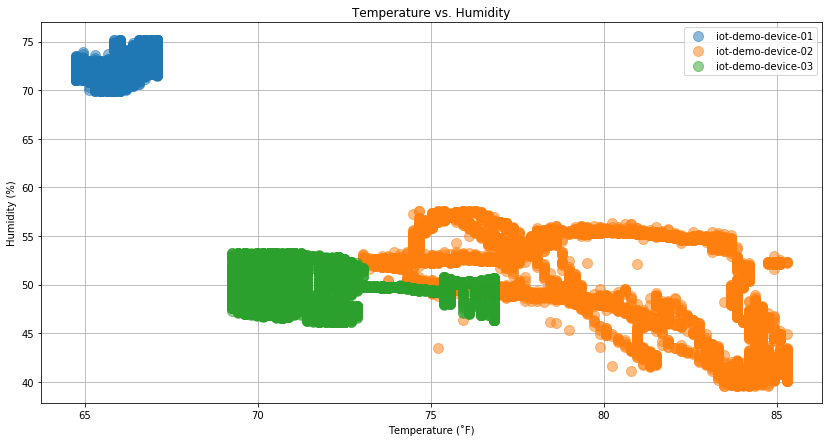

In [11]:
_, ax = plt.subplots(1, 1, figsize=(14, 7))
for device, group in groups:
    ax.plot(group.temp,
            group.humidity,
            marker="o",
            linestyle="",
            alpha=.5,
            ms=10,
            label=device)
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title("Temperature vs. Humidity")
plt.xlabel("Temperature (˚F)")
plt.ylabel("Humidity (%)")
plt.show()

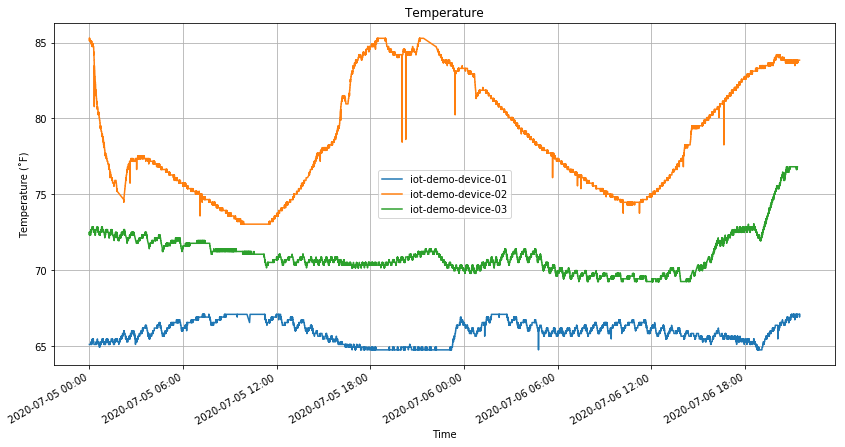

In [12]:
register_matplotlib_converters()
myFmt = DateFormatter("%Y-%m-%d %H:%M")

fig, ax = plt.subplots(1, 1, figsize=(14, 7))
for device, group in groups:
    ax.plot(group.temp,
            label=device)
ax.xaxis.set_major_formatter(myFmt)
fig.autofmt_xdate()
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title("Temperature")
plt.ylabel("Temperature (˚F)")
plt.xlabel("Time")
plt.show()

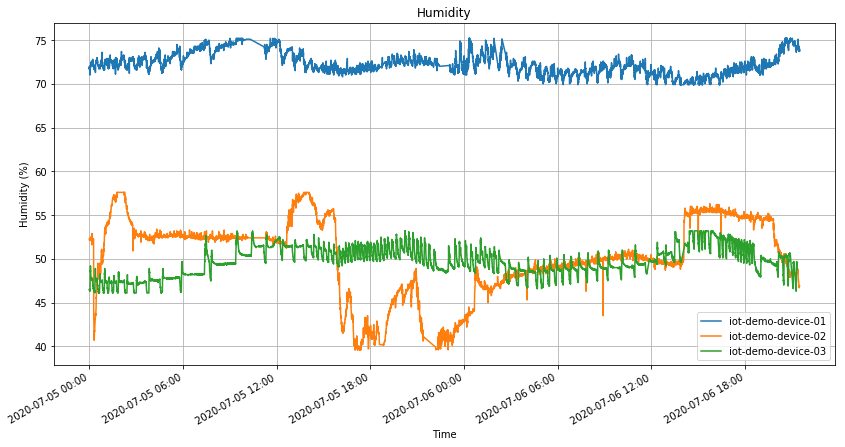

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
for device, group in groups:
    ax.plot(group.humidity,
            label=device)
ax.xaxis.set_major_formatter(myFmt)
fig.autofmt_xdate()
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title("Humidity")
plt.ylabel("Humidity (%)")
plt.xlabel("Time")
plt.show()